# Fully connected NN for D_s^+ analysis

In [1]:
# Use Python 3.8.10 on UNITO HPC4AI MLJC computing node - Tensorflow supporting GPU with libcudart.so.10.1
import numpy as np
np.random.seed(19)

import scipy as sp
from scipy.io import loadmat
#from scipy.fft import *
#from scipy.signal import convolve2d

import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras import regularizers
import keras
import keras_tuner
import visualkeras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

from matplotlib import pyplot as plt

import os
import sys
import argparse
import pickle
import yaml

from hipe4ml import plot_utils
from hipe4ml.tree_handler import TreeHandler

#import seaborn as sb
#import plotly.express as px

if tf.config.list_physical_devices('GPU'):
    print('GPU is available! (', tf.config.list_physical_devices(), ")")
else:
    print('GPU not properly loaded! Training is going to run on CPU')

2023-07-16 07:58:05.428135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 07:58:06.008194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU is available! ( [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] )


Failed to load image Python extension: /home/fchinu/.virtualenv/ml/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE


### Data preparation

In [ ]:
def data_prep(inputCfg, iBin, PtBin, OutPutDirPt, PromptDf, FDDf, BkgDf): #pylint: disable=too-many-statements, too-many-branches
    '''
    function for data preparation
    '''
    nPrompt = len(PromptDf)
    nFD = len(FDDf)
    nBkg = len(BkgDf)
    if FDDf.empty:
        out = f'\n     Signal: {nPrompt}\n     Bkg: {nBkg}'
    else:
        out = f'\n     Prompt: {nPrompt}\n     FD: {nFD}\n     Bkg: {nBkg}'
    print(f'Number of available candidates in {PtBin[0]} < pT < {PtBin[1]} GeV/c:{out}')

    dataset_opt = inputCfg['data_prep']['dataset_opt']
    seed_split = inputCfg['data_prep']['seed_split']
    test_f = inputCfg['data_prep']['test_fraction']

    if dataset_opt == 'equal':
        if FDDf.empty:
            nCandToKeep = min([nPrompt, nBkg])
            out = 'signal'
            out2 = 'signal'
        else:
            nCandToKeep = min([nPrompt, nFD, nBkg])
            out = 'prompt, FD'
            out2 = 'prompt'
        print((f'Keep same number of {out} and background (minimum) for training and '
               f'testing ({1 - test_f}-{test_f}): {nCandToKeep}'))
        print(f'Fraction of real data candidates used for ML: {nCandToKeep/nBkg:.5f}')

        if nPrompt > nCandToKeep:
            print((f'Remaining {out2} candidates ({nPrompt - nCandToKeep})'
                   'will be used for the efficiency together with test set'))
        if nFD > nCandToKeep:
            print((f'Remaining FD candidates ({nFD - nCandToKeep}) will be used for the '
                   'efficiency together with test set'))

        TotDf = pd.concat([BkgDf.iloc[:nCandToKeep], PromptDf.iloc[:nCandToKeep], FDDf.iloc[:nCandToKeep]], sort=True)
        if FDDf.empty:
            LabelsArray = np.array([0]*nCandToKeep + [1]*nCandToKeep)
        else:
            LabelsArray = np.array([0]*nCandToKeep + [1]*nCandToKeep + [2]*nCandToKeep)
        if test_f < 1:
            TrainSet, TestSet, yTrain, yTest = train_test_split(TotDf, LabelsArray, test_size=test_f,
                                                                random_state=seed_split)
        else:
            TrainSet = pd.DataFrame()
            TestSet = TotDf.copy()
            yTrain = pd.Series()
            yTest = LabelsArray.copy()

        TrainTestData = [TrainSet, yTrain, TestSet, yTest]
        PromptDfSelForEff = pd.concat([PromptDf.iloc[nCandToKeep:], TestSet[pd.Series(yTest).array == 1]], sort=False)
        if FDDf.empty:
            FDDfSelForEff = pd.DataFrame()
        else:
            FDDfSelForEff = pd.concat([FDDf.iloc[nCandToKeep:], TestSet[pd.Series(yTest).array == 2]], sort=False)
        del TotDf

    elif dataset_opt == 'max_signal':
        nCandBkg = round(inputCfg['data_prep']['bkg_mult'][iBin] * (nPrompt + nFD))
        out = 'signal' if FDDf.empty else 'prompt and FD'
        print((f'Keep all {out} and use {nCandBkg} bkg candidates for training and '
               f'testing ({1 - test_f}-{test_f})'))
        if nCandBkg >= nBkg:
            nCandBkg = nBkg
            print('\033[93mWARNING: using all bkg available, not good!\033[0m')
        print(f'Fraction of real data candidates used for ML: {nCandBkg/nBkg:.5f}')

        TotDf = pd.concat([BkgDf.iloc[:nCandBkg], PromptDf, FDDf], sort=True)
        if FDDf.empty:
            LabelsArray = np.array([0]*nCandBkg + [1]*nPrompt)
        else:
            LabelsArray = np.array([0]*nCandBkg + [1]*nPrompt + [2]*nFD)
        if test_f < 1:
            TrainSet, TestSet, yTrain, yTest = train_test_split(TotDf, LabelsArray, test_size=test_f,
                                                                random_state=seed_split)
        else:
            TrainSet = pd.DataFrame()
            TestSet = TotDf.copy()
            yTrain = pd.Series()
            yTest = LabelsArray.copy()

        TrainTestData = [TrainSet, yTrain, TestSet, yTest]
        PromptDfSelForEff = TestSet[pd.Series(yTest).array == 1]
        FDDfSelForEff = pd.DataFrame() if FDDf.empty else TestSet[pd.Series(yTest).array == 2]
        del TotDf

    else:
        print(f'\033[91mERROR: {dataset_opt} is not a valid option!\033[0m')
        sys.exit()

    # plots
    VarsToDraw = inputCfg['plots']['plotting_columns']
    LegLabels = [inputCfg['output']['leg_labels']['Bkg'],
                 inputCfg['output']['leg_labels']['Prompt']]
    if inputCfg['output']['leg_labels']['FD'] is not None:
        LegLabels.append(inputCfg['output']['leg_labels']['FD'])
    OutputLabels = [inputCfg['output']['out_labels']['Bkg'],
                    inputCfg['output']['out_labels']['Prompt']]
    if inputCfg['output']['out_labels']['FD'] is not None:
        OutputLabels.append(inputCfg['output']['out_labels']['FD'])
    ListDf = [BkgDf, PromptDf] if FDDf.empty else [BkgDf, PromptDf, FDDf]
    #_____________________________________________
    plot_utils.plot_distr(ListDf, VarsToDraw, 100, LegLabels, figsize=(12, 7),
                          alpha=0.3, log=True, grid=False, density=True)
    plt.subplots_adjust(left=0.06, bottom=0.1, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
    plt.savefig(f'{OutPutDirPt}/DistributionsAll_pT_{PtBin[0]}_{PtBin[1]}.png')
    plt.close('all')
    Var=['cos_p', 'cos_p_xy', 'd_len', 'd_len_xy', 'norm_dl_xy', 'imp_par_xy', 'sig_vert','delta_mass_KK','nsigComb_K_1']

    plot_utils.plot_distr(ListDf, Var, 100, LegLabels, figsize=(12, 7),
                        alpha=0.3, log=True, grid=False, density=True)
    plt.subplots_adjust(left=0.06, bottom=0.06, right=0.99, top=0.96, hspace=0.55, wspace=0.55)
    plt.savefig(f'{OutPutDirPt}/Distributionsselected_{PtBin[0]}_{PtBin[1]}.png')
    plt.close('all')
    #_____________________________________________
    CorrMatrixFig = plot_utils.plot_corr(ListDf, VarsToDraw, LegLabels)
    for Fig, Lab in zip(CorrMatrixFig, OutputLabels):
        plt.figure(Fig.number)
        plt.subplots_adjust(left=0.2, bottom=0.25, right=0.95, top=0.9)
        Fig.savefig(f'{OutPutDirPt}/CorrMatrix{Lab}_pT_{PtBin[0]}_{PtBin[1]}.pdf')

    return TrainTestData, PromptDfSelForEff, FDDfSelForEff

In [ ]:
cfgFileName = '/home/fchinu/DmesonAnalysis/ML/Config_NN.yml'

print('Loading analysis configuration: ...', end='\r')
with open(cfgFileName, 'r') as ymlCfgFile:
    inputCfg = yaml.load(ymlCfgFile, yaml.FullLoader)
print('Loading analysis configuration: Done!')

print('Loading and preparing data files: ...', end='\r')
PromptHandler = TreeHandler(inputCfg['input']['prompt'], inputCfg['input']['treename'])
FDHandler = None if inputCfg['input']['FD'] is None else TreeHandler(inputCfg['input']['FD'],
                                                                        inputCfg['input']['treename'])
DataHandler = TreeHandler(inputCfg['input']['data'], inputCfg['input']['treename'])

if inputCfg['data_prep']['filt_bkg_mass']:
    BkgHandler = DataHandler.get_subset(inputCfg['data_prep']['filt_bkg_mass'], frac=1.,
                                        rndm_state=inputCfg['data_prep']['seed_split'])
else:
    BkgHandler = DataHandler

PtBins = [[a, b] for a, b in zip(inputCfg['pt_ranges']['min'], inputCfg['pt_ranges']['max'])]
PromptHandler.slice_data_frame('pt_cand', PtBins, True)
if FDHandler is not None:
    FDHandler.slice_data_frame('pt_cand', PtBins, True)
DataHandler.slice_data_frame('pt_cand', PtBins, True)
BkgHandler.slice_data_frame('pt_cand', PtBins, True)
print('Loading and preparing data files: Done!')

for iBin, PtBin in enumerate(PtBins):
    print(f'\n\033[94mStarting ML analysis --- {PtBin[0]} < pT < {PtBin[1]} GeV/c\033[0m')

    OutPutDirPt = os.path.join(os.path.expanduser(inputCfg['output']['dir']), f'pt{PtBin[0]}_{PtBin[1]}')
    if os.path.isdir(OutPutDirPt):
        print((f'\033[93mWARNING: Output directory \'{OutPutDirPt}\' already exists,'
                ' overwrites possibly ongoing!\033[0m'))
    else:
        os.makedirs(OutPutDirPt)

    # data preparation
    #_____________________________________________
    FDDfPt = pd.DataFrame() if FDHandler is None else FDHandler.get_slice(iBin)
    TrainTestData, PromptDfSelForEff, FDDfSelForEff = data_prep(inputCfg, iBin, PtBin, OutPutDirPt,
                                                                PromptHandler.get_slice(iBin), FDDfPt,
                                                                BkgHandler.get_slice(iBin))

In [ ]:
n_classes = len(np.unique(TrainTestData[3]))
if n_classes==2:
    out_dim=1
else:
    out_dim=n_classes
TrainCols = inputCfg['ml']['training_columns']

TrainFeatures = np.asarray(TrainTestData[0][TrainCols]).astype('float32').reshape((-1,len(TrainCols)))
TrainLabels = np.asarray(TrainTestData[1]).astype('float32').reshape((-1,1))
TestFeatures = np.asarray(TrainTestData[2][TrainCols]).astype('float32').reshape((-1,len(TrainCols)))
TestLabels = np.asarray(TrainTestData[3]).astype('float32').reshape((-1,1))
TrainFeatures, ValFeatures, TrainLabels, ValLabels = train_test_split(TrainFeatures, TrainLabels, test_size=0.2, random_state=42)
print(ValLabels.shape)

In [ ]:
Datasets = {'TrainFeatures' : TrainFeatures, 'TrainLabels' : TrainLabels,
            'TestFeatures' : TestFeatures, 'TestLabels' : TestLabels,
            'ValFeatures' : ValFeatures, 'ValLabels' : ValLabels}

with open('/home/fchinu/DmesonAnalysis/ML/NN_Outputs/data/Dataset.p', 'wb') as handle:
    pickle.dump(Datasets, handle, protocol=pickle.HIGHEST_PROTOCOL);

### Model Definition

In [2]:
def build_model(hp):
    # CNN 1D
    model = Sequential()
    model.add(Dense(hp.Int("dense1", 64,256, step = 2, sampling = "log"), activation='relu',input_dim=16))
    model.add(Dense(hp.Int("dense2", 64,256, step = 2, sampling = "log"), activation='relu'))
    model.add(Dense(hp.Int("dense3", 64,256, step = 2, sampling = "log"), activation='relu'))
    model.add(Dense(hp.Int("dense4", 64,256, step = 2, sampling = "log"), activation='relu'))
    model.add(Dense(hp.Int("dense5", 64,256, step = 2, sampling = "log"), activation='relu'))
    model.add(Dense(hp.Int("dense6", 64,256, step = 2, sampling = "log"), activation='relu'))
    #model.add(Dense(hp.Int("dense3", 16,1024, step = 2, sampling = "log"), activation='relu'))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dense(hp.Int("dense5", 4,256, step = 2, sampling = "log"), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
        
        
    
    # Minimizer
    optim = keras.optimizers.Adam(learning_rate = hp.Float("learning_rate", 1e-4,1e-2, step = 5e-4, sampling = "linear"))

    # Compile
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    # Print summary
    model.summary()
    return model 

In [3]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

### Dataset extraction

In [4]:
with open('/home/fchinu/DmesonAnalysis/ML/NN_Outputs/data/Dataset.p', 'rb') as handle:
    Datasets = pickle.load(handle)
    
TrainFeatures = Datasets['TrainFeatures']
TrainLabels = Datasets['TrainLabels']
TestFeatures = Datasets['TestFeatures']
TestLabels = Datasets['TestLabels']
ValFeatures = Datasets['ValFeatures']
ValLabels = Datasets['ValLabels']

### Featrues scaling

In [5]:
TrainFeatures = preprocessing.StandardScaler().fit_transform(TrainFeatures) 
TestFeatures = preprocessing.StandardScaler().fit_transform(TestFeatures)
ValFeatures = preprocessing.StandardScaler().fit_transform(ValFeatures)

### Hyperparameters tuning

In [23]:
tf.autograph.set_verbosity(0)
#Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization" by Lisha Li et al. in 2018
tuner = keras_tuner.Hyperband( 
    build_model,
    project_name = 'NN',
    objective = 'val_loss',
    max_epochs = 10,
    hyperband_iterations=2,
    overwrite = True)
   
tuner.search(TrainFeatures, TrainLabels, epochs=5, validation_data=(ValFeatures, ValLabels), callbacks=[stop_early], workers=8, batch_size=20, use_multiprocessing = True)

# Choose the best model
modelList = tuner.get_best_models()
model = modelList[0]

Trial 27 Complete [00h 16m 37s]
val_loss: 0.2737806737422943

Best val_loss So Far: 0.21033935248851776
Total elapsed time: 02h 28m 19s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
128               |256               |dense1
64                |256               |dense2
64                |64                |dense3
64                |128               |dense4
256               |256               |dense5
256               |128               |dense6
0.0036            |0.0006            |learning_rate
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2176      
                               

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
final_hp_choice = keras_tuner.HyperParameters()

final_hp_choice.Fixed('dense1'  , value = 256)
final_hp_choice.Fixed('dense2'  , value = 256)
final_hp_choice.Fixed('dense3'  , value = 64)
final_hp_choice.Fixed('dense4'  , value = 128)
final_hp_choice.Fixed('dense5'  , value = 256)
final_hp_choice.Fixed('dense6'  , value = 128)
final_hp_choice.Fixed('learning_rate', value = 0.0006)

model = build_model(final_hp_choice)

In [ ]:
visualkeras.layered_view(model, legend=True, draw_volume=True)

In [ ]:
model_dict_hp = {'hyperparam_optimized_model': model};

with open('/home/fchinu/DmesonAnalysis/ML/NN_Outputs/model/hyperParamOpt.p', 'wb') as handle:
    pickle.dump(model_dict_hp, handle, protocol=pickle.HIGHEST_PROTOCOL);
    
model.save('/home/fchinu/DmesonAnalysis/ML/NN_Outputs/model/hpOptim');
model.save_weights('/home/fchinu/DmesonAnalysis/ML/NN_Outputs/model/empty_weights.h5')

### Model Training

In [10]:
def load_untrained_best_model():
    final_hp_choice = keras_tuner.HyperParameters()

    final_hp_choice.Fixed('dense1'  , value = 256)
    final_hp_choice.Fixed('dense2'  , value = 256)
    final_hp_choice.Fixed('dense3'  , value = 64)
    final_hp_choice.Fixed('dense4'  , value = 128)
    final_hp_choice.Fixed('dense5'  , value = 256)
    final_hp_choice.Fixed('dense6'  , value = 128)
    final_hp_choice.Fixed('learning_rate', value = 0.0006)

    model = build_model(final_hp_choice)
    #model.load_weights('/home/fchinu/DmesonAnalysis/ML/NN_Outputs/model/empty_weights.h5')
    return model

In [11]:
tf.autograph.set_verbosity(0, False)
model = load_untrained_best_model()

# Start the training process
history = model.fit(TrainFeatures, TrainLabels, validation_data=(ValFeatures, ValLabels), epochs=50, batch_size=20, callbacks = [stop_early])
model.save_weights('/home/fchinu/DmesonAnalysis/ML/NN_Outputs/model/fullTraining.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               4352      
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 256)               33024     
                                                                 
 dense_19 (Dense)            (None, 128)               32896     
                                                                 
 dense_20 (Dense)            (None, 1)                

Epoch 1/50
50846/50846 [==============================] - 96s 2ms/step - loss: 0.2316 - accuracy: 0.9032 - val_loss: 0.2184 - val_accuracy: 0.9091
Epoch 2/50
50846/50846 [==============================] - 95s 2ms/step - loss: 0.2178 - accuracy: 0.9094 - val_loss: 0.2192 - val_accuracy: 0.9098
Epoch 3/50
50846/50846 [==============================] - 96s 2ms/step - loss: 0.2145 - accuracy: 0.9110 - val_loss: 0.2148 - val_accuracy: 0.9112
Epoch 4/50
50846/50846 [==============================] - 96s 2ms/step - loss: 0.2128 - accuracy: 0.9116 - val_loss: 0.2146 - val_accuracy: 0.9121
Epoch 5/50
50846/50846 [==============================] - 95s 2ms/step - loss: 0.2113 - accuracy: 0.9126 - val_loss: 0.2136 - val_accuracy: 0.9121
Epoch 6/50
50846/50846 [==============================] - 95s 2ms/step - loss: 0.2104 - accuracy: 0.9129 - val_loss: 0.2120 - val_accuracy: 0.9112
Epoch 7/50
50846/50846 [==============================] - 96s 2ms/step - loss: 0.2096 - accuracy: 0.9133 - val_loss: 0

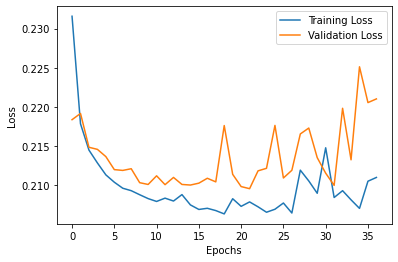

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

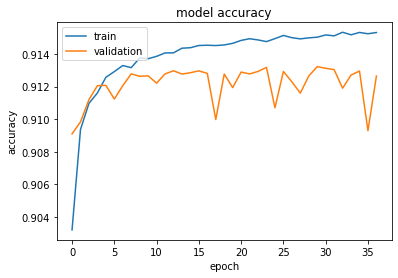

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model evaluation on the test set

In [14]:
score, acc = model.evaluate(TestFeatures, TestLabels)
print('Test score:', score)
print('Test accuracy:', acc)

   1/9931 [..............................] - ETA: 4:34 - loss: 0.4069 - accuracy: 0.8125

9931/9931 [==============================] - 11s 1ms/step - loss: 0.2238 - accuracy: 0.9127
Test score: 0.2237953394651413
Test accuracy: 0.912749707698822


### ROC curves

In [15]:
model.load_weights('/home/fchinu/DmesonAnalysis/ML/NN_Outputs/model/fullTraining.h5')
TrainPredicted = model.predict(TrainFeatures)
Trainfpr, Traintpr, Trainthresholds = roc_curve(TrainLabels, TrainPredicted, pos_label=1)
TestPredicted = model.predict(TestFeatures)
Testfpr, Testtpr, Testthresholds = roc_curve(TestLabels, TestPredicted, pos_label=1)
print('Train ROC AUC', roc_auc_score(TrainLabels, TrainPredicted))
print('Test ROC AUC', roc_auc_score(TestLabels, TestPredicted))

9931/9931 [==============================] - 7s 706us/step
Train ROC AUC 0.9730783506073815
Test ROC AUC 0.971234774310306


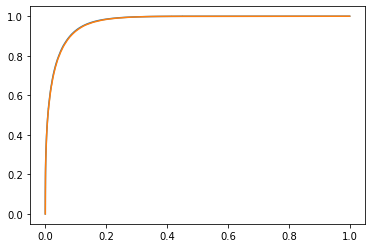

In [20]:
plt.plot(Trainfpr, Traintpr, label='train')
plt.plot(Testfpr, Testtpr, label='test')
